# Helmholtz Dirichlet problem (easyFEMpkg)

Solve: find $u$ such that

$-\Delta u - k^2 u = 0$ in $\Omega$, with Dirichlet $u=g$ on $\partial\Omega$.

For simplicity, we will assume $k=\pi\omega$. In that case, by choosing g accordingly, the exact solution will be:
$$u(x,y) = \sin(kx/\sqrt{2})\sin(ky/\sqrt{2}).$$

In [1]:
import math, numpy as np
import matplotlib.pyplot as plt
from easyFEMpkg.mesh import build_mesh
from easyFEMpkg.assemble import assemble_dirichlet, solve_system
from easyFEMpkg.plotting import show_mesh, trisurf_like, mesh_and_solution_side_by_side, trisurf_side_by_side
from easyFEMpkg.main import compute_error_norms

In [2]:
geometry = 'square'

#Set up the parameters for Helmholtz equation
omega = 1.0
k = np.pi*omega  # wave number

# The code assumes it solves -Δu - c u = f.
# Helmholtz: -Δu - k^2 u = 0  => interior coefficient c(x,y) = -(k**2)
def c(x, y):
    return -(k**2)

# Set up dirichlet data
def g(x, y):
    return math.sin(k/math.sqrt(2)*x)*math.sin(k/math.sqrt(2)*y)

In [3]:
# In order to consider different refinements, we need to pass a 'reference meshwidth'
#h_ref = [0.25, 0.125, 0.0625, 0.03125, 0.015625, 0.015625/2]
h_ref = [0.25, 0.125, 0.0625, 0.03125, 0.015625]
# Note that we haven't implemented an actual refinement routine. Instead, 
# we will be simply generating finer meshes (i.e. we will have a sequence of meshes that is not nested).

__Task 1:__ Let us play with sampling!

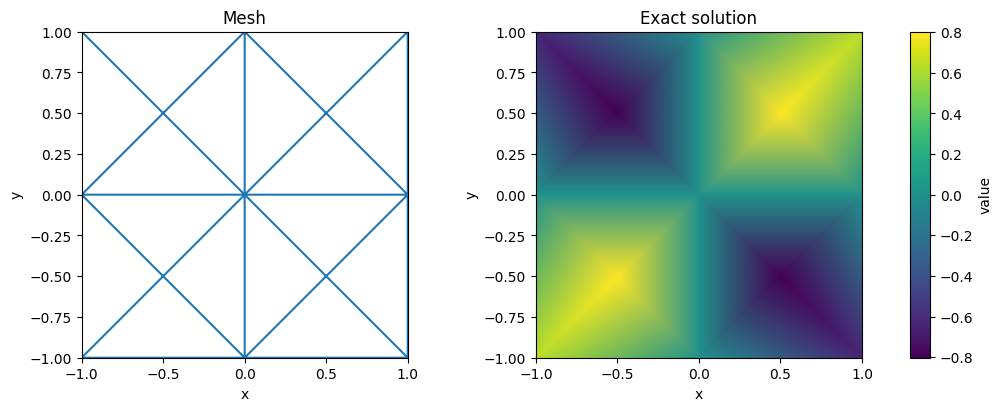

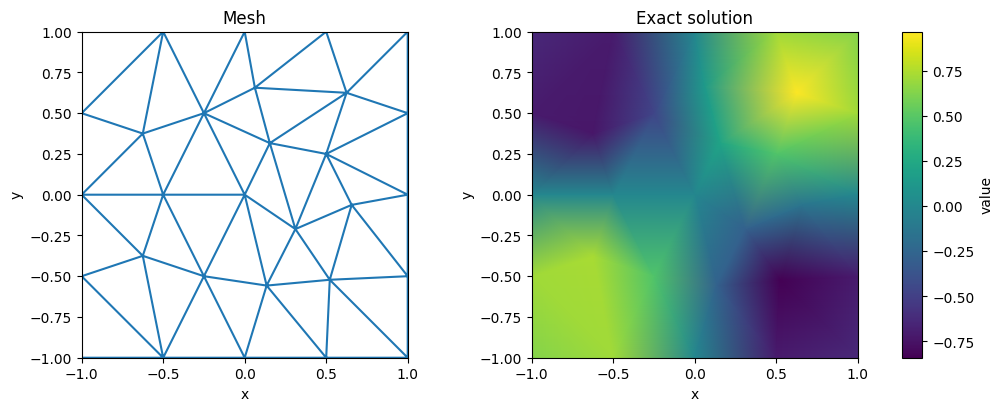

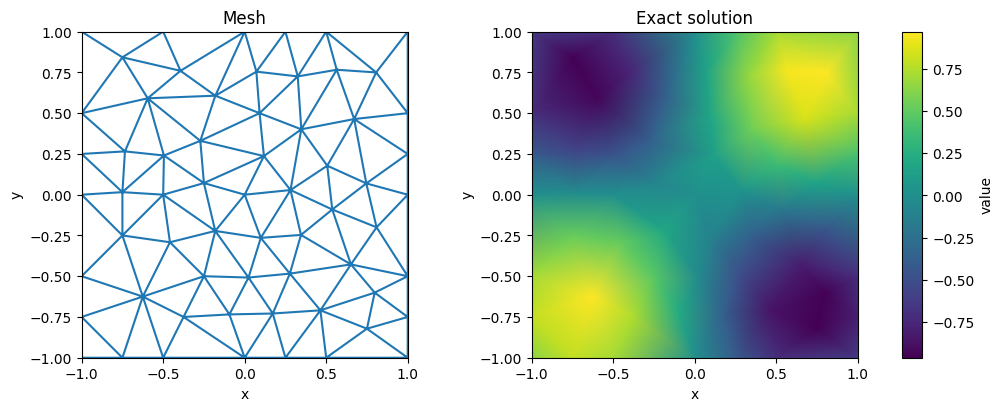

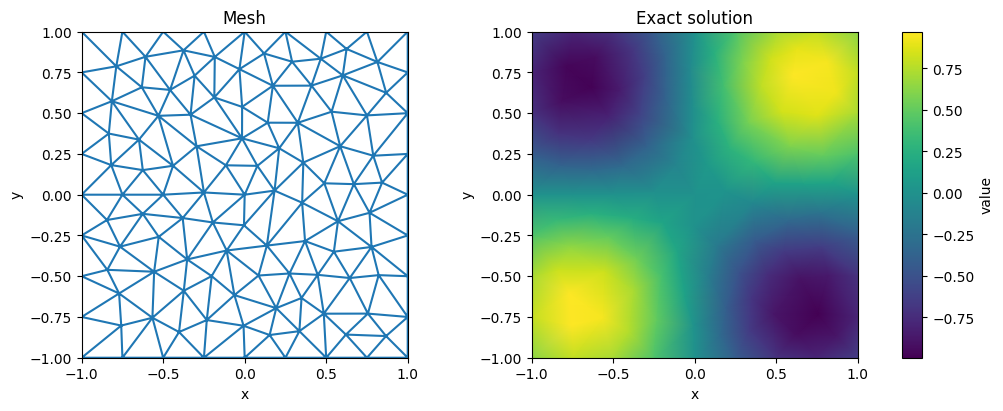

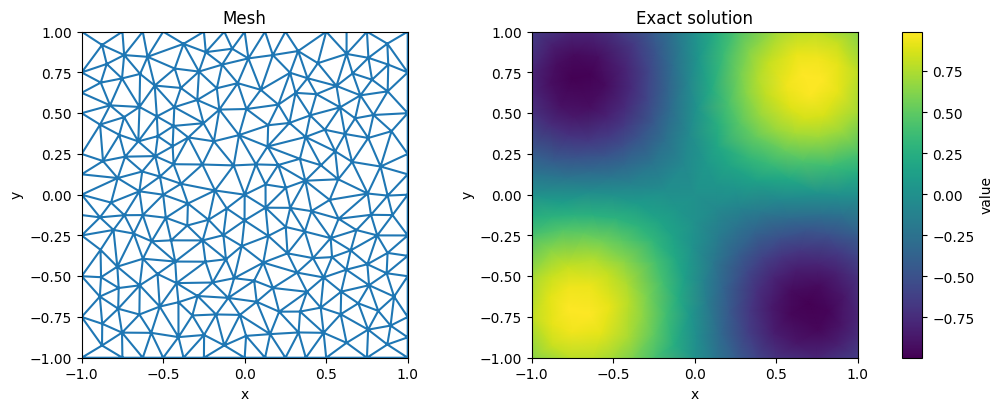

In [4]:
for max_area in h_ref:
    # Build the mesh and retrieve the mesh data:
    # p: mesh vertices
    # t: mesh elements (this is an array containing the numbering of the vertices that belong to the triangle)
    # bnd: array containing the boundary edges. This will be used for setting boundary conditions when needed.
    p, t, bnd = build_mesh(geometry, max_area=max_area)
    
    #Plot the exact solution  
    u_ref = np.array([g(x,y) for (x,y) in p])
    mesh_and_solution_side_by_side(p, t, u_ref, title="Exact solution")

__Task 2:__ Let us play with the pollution effect!

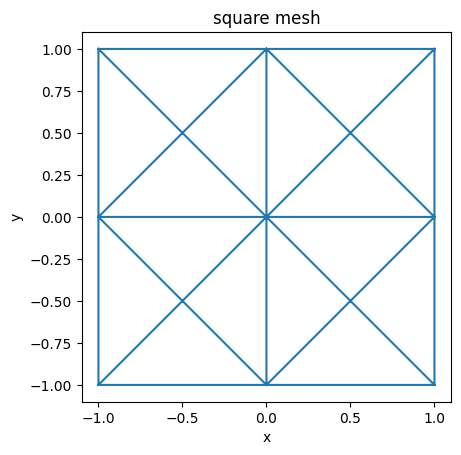

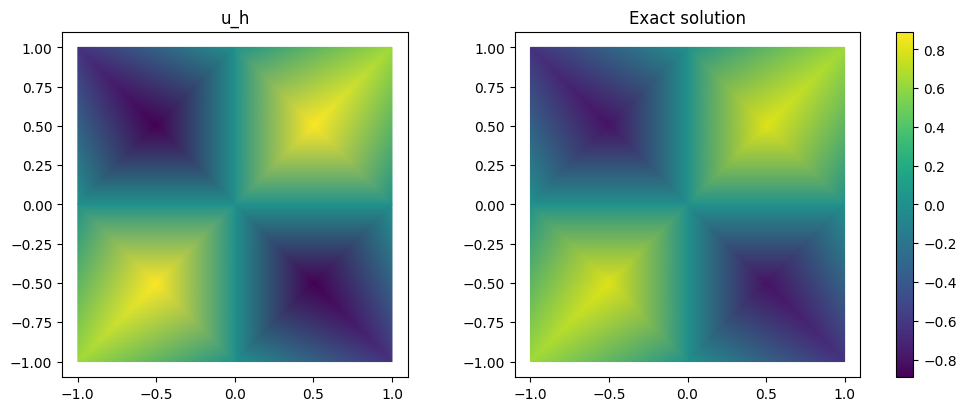

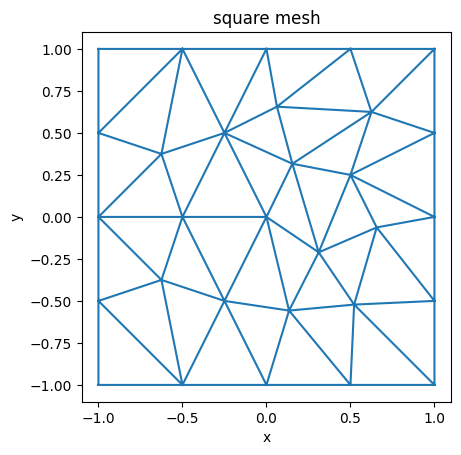

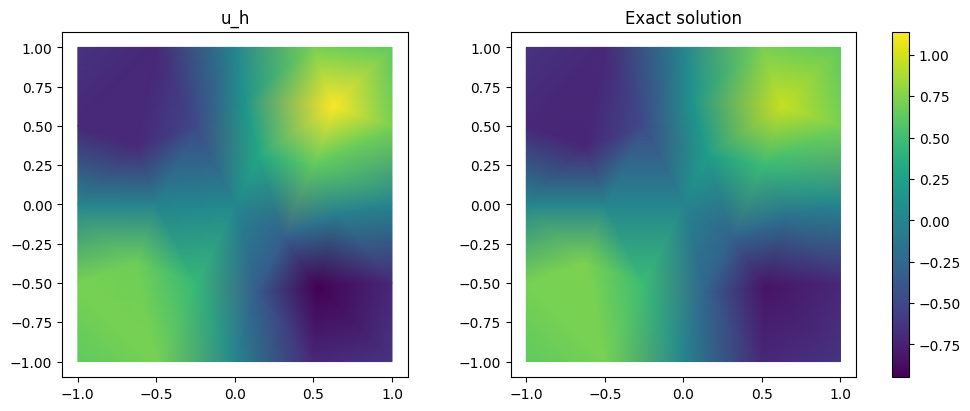

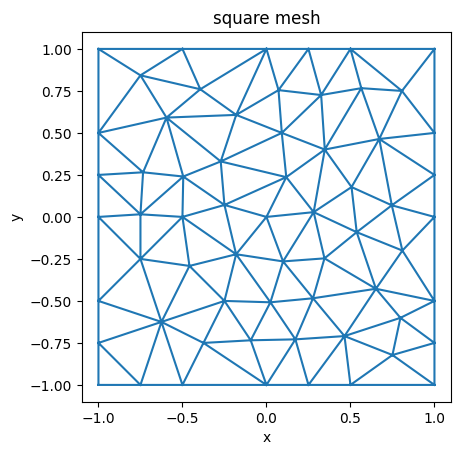

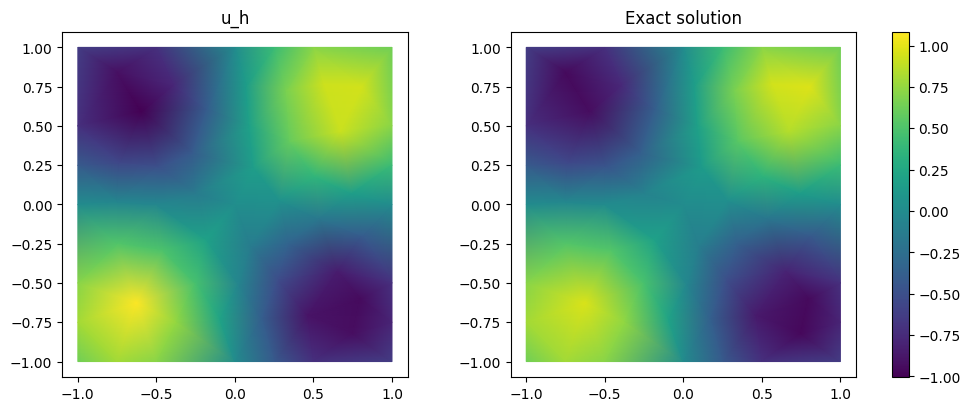

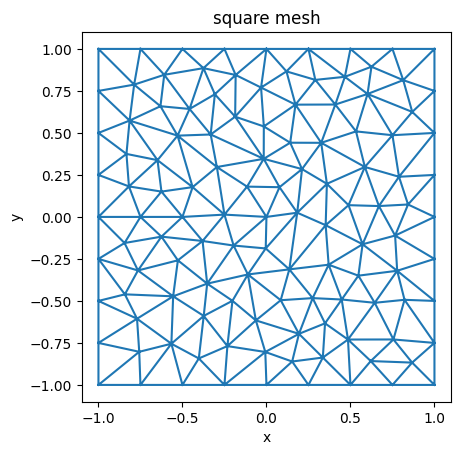

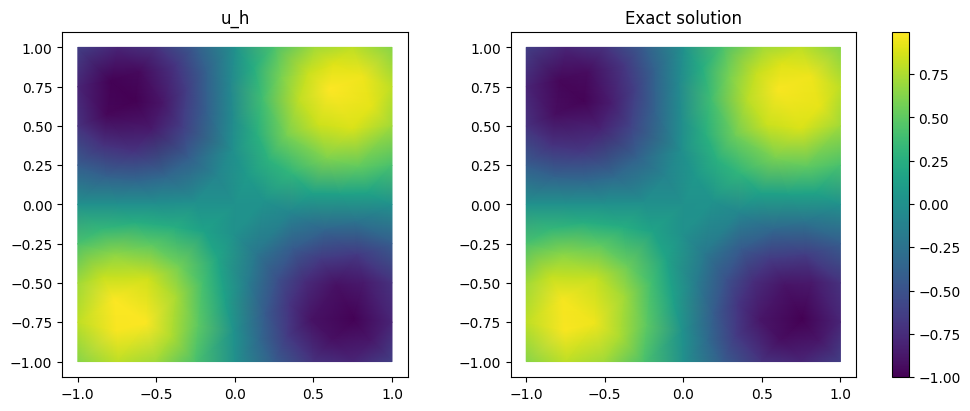

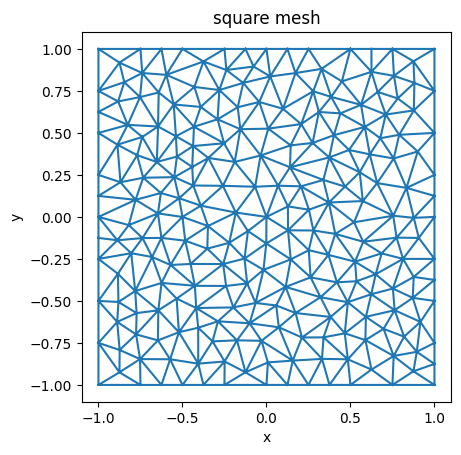

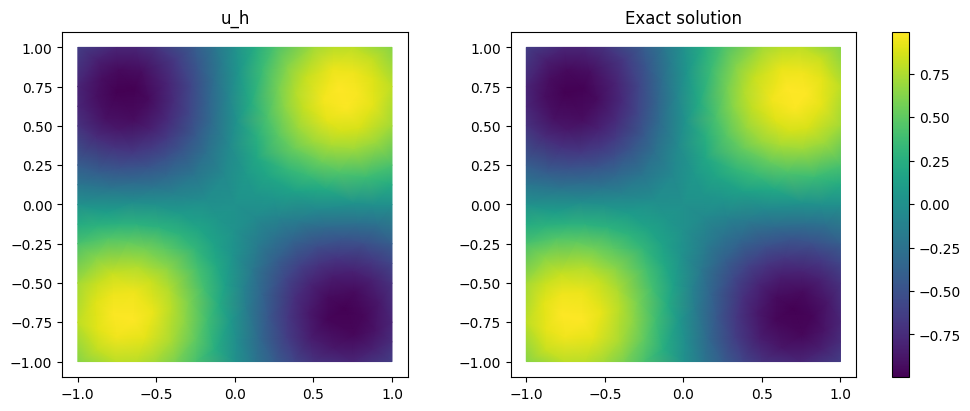

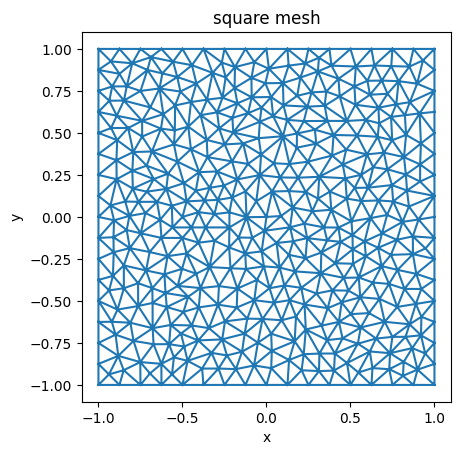

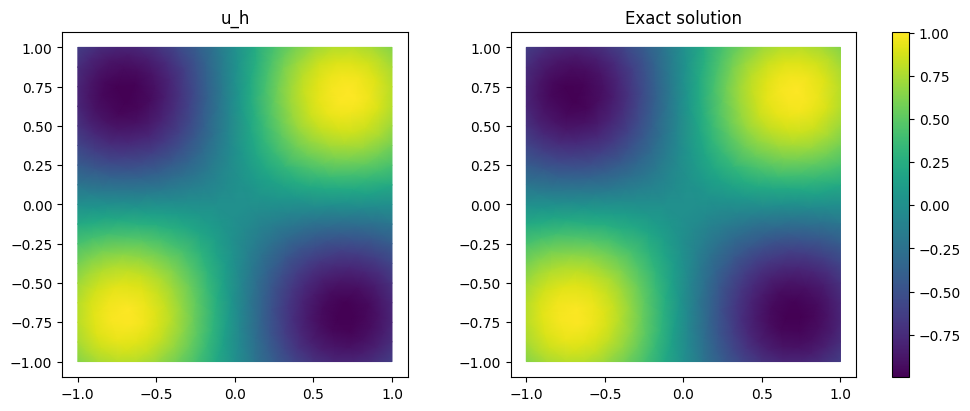

In [9]:
#Iterate over the different mesh refinements to see how the solution changes. We will compute the error as well.
L2_err = np.zeros(len(h_ref))
H1_err = np.zeros(len(h_ref))
m=0
for max_area in h_ref:
    # Build the mesh and retrieve the mesh data:
    # p: mesh vertices
    # t: mesh elements (this is an array containing the numbering of the vertices that belong to the triangle)
    # bnd: array containing the boundary edges. This will be used for setting boundary conditions when needed.
    p, t, bnd = build_mesh(geometry, max_area=max_area)
    
    # Assemble the system matrix S and the right hand side f. The code assumes it solves -Δu - c u = f. 
    # If no f is passed as argument, it assumes f=0.
    S, F = assemble_dirichlet(p, t, bnd, c, g)
    
    # Solve the system to find the coefficient vector
    u = solve_system(S, F)
    
    #Plot the mesh
    show_mesh(p, t, f"{geometry} mesh")
    
    #Plot the solution          
    #trisurf_like(p, t, np.real(u), title='Helmholtz Dirichlet — real(u)')
    #trisurf_like(p, t, np.imag(u), title='Helmholtz Dirichlet — imag(u)')
    #mesh_and_solution_side_by_side(p, t, np.real(u), title="Helmholtz — real(u)")
    u_ref = np.array([g(x,y) for (x,y) in p])
    trisurf_side_by_side(p, t, np.real(u), u_ref, titles=("u_h","Exact solution"))
    
    #Compute the error when compared to the reference solution (Exact solution = g)
    grad_exact=lambda x,y: (k/math.sqrt(2)*math.cos(k/math.sqrt(2)*x)*math.sin(k/math.sqrt(2)*y), 
                            k/math.sqrt(2)*math.sin(k/math.sqrt(2)*x)*math.cos(k/math.sqrt(2)*y))
    L2_err[m], H1_err[m] = compute_error_norms(p, t, np.real(u), g, grad_exact)
    m=m+1
    


[0.25, 0.125, 0.0625, 0.03125, 0.015625, 0.0078125]
[0.10243763 0.12365557 0.06562759 0.03151245 0.0111824  0.0068191 ]
[1.08687645 0.95131543 0.5243574  0.32967298 0.23537257 0.15632159]


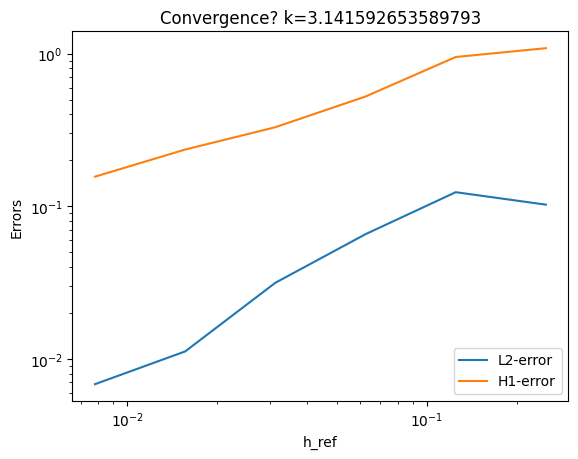

In [10]:
print(h_ref),print(L2_err), print(H1_err)

plt.loglog(h_ref, L2_err)
plt.loglog(h_ref, H1_err)
plt.title('Convergence? k='+str(k))
plt.xlabel('h_ref'); plt.ylabel('Errors')
plt.legend(["L2-error", "H1-error"], loc="lower right")
plt.show()